dt:  0.7456162171191814


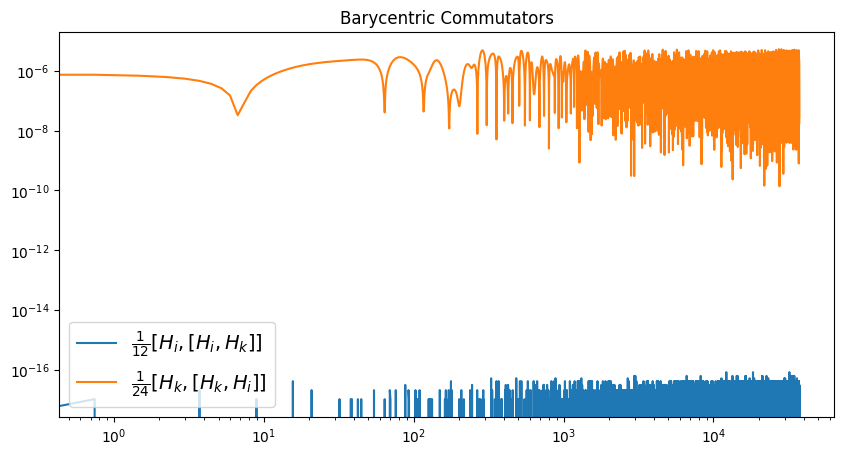

In [5]:
import rebound
from ctypes import byref
from ctypes import c_double as double
import numpy as np
import matplotlib.pyplot as plt
import rebound.data as data
c = rebound.clibrebound

def kepler_operator(r, dt):
    dt = double(dt)
    c.reb_integrator_whfast_from_inertial(r);
    c.reb_whfast_com_step(r,dt);
    c.reb_whfast_kepler_step(r,dt);
    c.reb_integrator_whfast_to_inertial(r);

def interaction_operator(r, dt):
    dt = double(dt)
    c.reb_integrator_whfast_to_inertial(r);
    c.reb_simulation_update_acceleration(r);
    c.reb_whfast_interaction_step(r,dt);
    #c.reb_integrator_whfast_from_inertial(r)
    

# [H_i,[H_i,H_k]]
def commutator_i_i_k(r,dt):
    ei = sim.energy();
    kepler_operator(r,dt/2.);
    interaction_operator(r,dt);
    kepler_operator(r,-dt/2.);
    interaction_operator(r,-dt);
    interaction_operator(r,dt); 
    interaction_operator(r,dt);
    kepler_operator(r,dt/2.);
    interaction_operator(r,-dt);
    kepler_operator(r,-dt/2.);
    interaction_operator(r,-dt);
    ef = sim.energy();
    return (np.abs(ef-ei)/np.abs(ei))/12.

# [H_k,[H_k,H_i]]
def commutator_k_k_i(r,dt):
    ei = sim.energy();
    interaction_operator(r,dt)
    kepler_operator(r,dt/2.)
    interaction_operator(r,-dt)
    kepler_operator(r,-dt/2.)
    kepler_operator(r,dt/2.)
    kepler_operator(r,dt/2.)
    interaction_operator(r,dt)
    kepler_operator(r,-dt/2.)
    interaction_operator(r,-dt)
    kepler_operator(r,-dt/2.)
    ef = sim.energy()
    return (np.abs(ef-ei)/np.abs(ei))/24.

def init_particles(sim):
    # sim.add(m=1.)
    # sim.add(m=1.,a=1.)
    data.add_outer_solar_system(sim)
    #data.add_solar_system(sim)

sim = rebound.Simulation()
sim.integrator= "whfast"
sim.ri_whfast.coordinates = "barycentric"
sim.ri_whfast.corrector = 0
r = byref(sim)
init_particles(sim)
p = sim.particles[1].P
dt = p/100.
print("dt: ",dt)
times = np.arange(0,500*sim.particles[1].P,dt)
iik = np.zeros(len(times))
kki = np.zeros(len(times))

for i,t in enumerate(times):
    sim.integrate(t)
    iik[i] = commutator_i_i_k(r,dt)
    kki[i] = commutator_k_k_i(r,dt)
    p = sim.particles[1].P

fig = plt.figure(figsize  = (10,5))
plt.title("Barycentric Commutators")
plt.plot(times,iik ,label=r"$\frac{1}{12}[H_i,[H_i,H_k]]$")
plt.plot(times,kki, label=r"$\frac{1}{24}[H_k,[H_k,H_i]]$")
plt.yscale('log')
plt.xscale('log')
plt.legend(loc = "lower left", fontsize=14)
plt.show()